# Buscador de imágenes con índice invertido

Genera un buscador de imágenes usando índice inverso y visualiza las imágenes con mayor
similitud de Jaccard, MinMax y Coseno. Para su implementación debes usar Spark.

Cisneros Aguilar Sara Kenia

In [1]:
#pip install pyspark

import pyspark
from pyspark import SparkContext 
import collections
from pyspark import SparkConf as scf

In [2]:
conf = scf().setMaster('local').setAppName('ParallelizedCollections')
sc = SparkContext(conf = conf)

## Resumen archivos

### Test - Train.mat
Contienen:
1. header
2. version
3. globals
4. test_info (tiene niveles)
    1. Ruta de las diferentes imagenes con extención
    2. Ruta de las diferentes imagenes sin extención
    3. Número de carpeta de la imagen x
    4. Histograma de información de la imagen x
5. test_fg_data 
6. test_data

### File, Test, Train list.mat

Contienen:
1. header
2. version
3. globals
4. file_list: Ruta de las diferentes imagenes con extención
5. annotation_list: Ruta de las diferentes imagenes sin extención
6. labels

### Annotation
Contiene las carpetas con los respectivos nombres de cada imagen

### List ent y val
Nombre de las imagenes de entrenamiento y validación

### Dogs ent val
Bolsa de caracteristicas de las imagenes de entrenamiento y validación, con 12000 imagenes

## Lectura de archivos
Leemos los nombres de las imagenes dividiendo en dos grupos, base y consulta, tomando ent_dogs y val_dogs respectivamente

In [5]:
nomBase = sc.textFile('lista_ent_dogs.txt')
print(nomBase.take(5))

['n02085620_5927', 'n02085620_4441', 'n02085620_1502', 'n02085620_1916', 'n02085620_13151']


In [6]:
nomCon = sc.textFile('lista_val_dogs.txt')
print(nomCon.take(5))

['n02085620_2650', 'n02085620_4919', 'n02085620_1765', 'n02085620_3006', 'n02085620_1492']


In [7]:
rut_base = nomBase.collect()
rut_con = nomCon.collect()

Leemos caracteristicas

In [8]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .master("local") \
     .appName("Word Count") \
     .config("spark.some.config.option", "some-value") \
     .getOrCreate()

In [9]:
file_type = "csv"
infer_schema = "true"
first_row_is_header = "false"
delimiter = " "
file_location1 = "dogs_ent.csv"
file_location2 = "dogs_val.csv"

bol_base = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location1)

bol_con = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location2)

In [10]:
# de lista de spark a rdd de spark
bol_base = bol_base.collect()
bol_con = bol_con.collect()

In [91]:
bolsaCon = []
for i in range(len(bol_base)):
    cont = bol_base[i][0]
    print(cont)
    l = []
    for j in range(cont):
        if type(bol_base[i][j]) == str:
            f = bol_base[i][j].split(':')[0]
            l.append(f)
    bolsaCon.append(l)

113


IndexError: tuple index out of range

## Visualización de imagenes
### Primero obtenemos las rutas de las imagenes que se tomaron de base y consulta, pues solo conocemos su nombre

In [11]:
import scipy.io as sci

In [12]:
test = sci.loadmat('test_data.mat')
print(test.keys())

dict_keys(['__header__', '__version__', '__globals__', 'test_info', 'test_fg_data', 'test_data'])


In [13]:
carpetas = set([])
for i in range(len(test['test_info'][0][0][1])):
    carpetas.add(test['test_info'][0][0][1][i][0][0].split(sep = '/')[0])
listCarp = list(carpetas)

In [14]:
rutaImBase = []
for i in range(len(rut_base)):
    subString = rut_base[i].split(sep = '_')[0]
    p = subString
    rutaImBase.append([(string + '/' + rut_base[i] + '.jpg') for string in listCarp if p in string])

rutaImCon = []
for i in range(len(rut_con)):
    subString = rut_con[i].split(sep = '_')[0]
    p = subString
    rutaImCon.append([(string + '/' + rut_con[i] + '.jpg') for string in listCarp if p in string])

### Imagenes de Base

In [20]:
import matplotlib.pyplot as plt

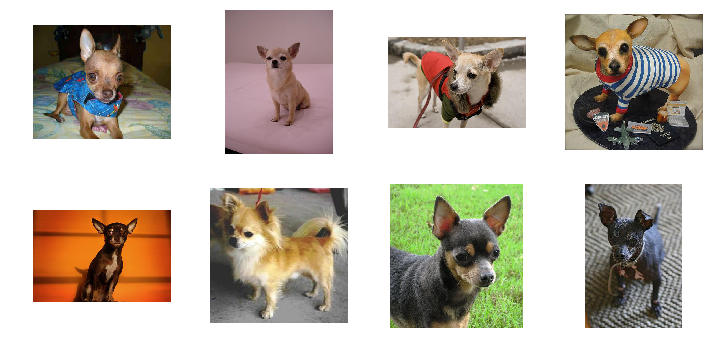

In [21]:
plt.figure(figsize = (10, 5))
for k, i in enumerate(rutaImBase[:8]):
    plt.subplot(2, 4, k + 1)
    imox = plt.imread('./images/' + i[0])
    plt.imshow(imox)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Imagenes de consulta

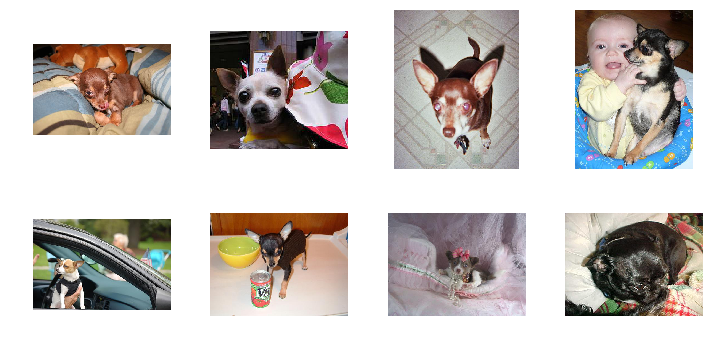

In [22]:
plt.figure(figsize = (10, 5))
for k, i in enumerate(rutaImCon[:8]):
    plt.subplot(2, 4, k + 1)
    imox = plt.imread('./images/' + i[0])
    plt.imshow(imox)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Indice inverso

## Similitudes
Calculamos la similitud con la imagen de consulta y las imagenes regresadas, las ordenamos por similitud

### Jaccard
$J(C^{(1)},C^{(2)}) = \frac{|C^{(1)} \cap C^{(2)}|}{|C^{(1)} \cup C^{(2)}|} \in [0,1]$

In [15]:
def similitud_Jaccard(x, y):
    inter = x.intersection(y)
    union = x.union(y)
    union = union.distinct()
    return inter.count()/union.count()

### MiniMax
$J(\beta^{(1)}, \beta^{(2)}) = \frac{\Sigma_{w=1}^{D} min(\beta_w^{(1)}, \beta_w^{(2)})}{\Sigma_{w=1}^{D} max(\beta_w^{(1)}, \beta_w^{(2)})} \in [0,1]$

donde:
$\beta_w^{(1)}, \beta_w^{(2)}$ son las multiplicidades del elemento $w$ de la bolsa $\beta^{(1)}$ y $\beta^{(2)}$ respectivamente.

In [16]:
def similitud_MiniMax(x, y):
    union = x.union(y)
    union = union.distinct()
    inter = x.intersection(y)
    minimo = inter.reduce(lambda x, y: x + y)
    maximo = union.reduce(lambda x, y: x + y)
    return minimo/maximo

### Coseno
$cos(\theta)=\frac{x \bullet y}{||x|| \bullet ||y||} = \frac{\Sigma_{i=1}^{L} x_i \bullet y_i}{\sqrt{\Sigma_{i=1}^{L} x_i^2} \bullet \sqrt{\Sigma_{i=1}^{L} y_i^2}}$

In [17]:
import math
def similitud_Coseno(x, y):
    x_2 = x.map(lambda x: x**2)
    sum_x2 = x_2.reduce(lambda x, y: x + y)
    y_2 = y.map(lambda y: y**2)
    sum_y2 = y_2.reduce(lambda x, y: x + y)
    union = x.union(y)
    sum_xy = union.map(lambda x, y: x * y)
    x = x.map(lambda x: x).collect()
    y = y.map(lambda y: y).collect()
    if len(x) > len(y):
        dif = len(x) - len(y)
        for i in range(dif):
            y.append(0)
    if len(x) < len(y):
        dif = len(y) - len(x)
        for i in range(dif):
            x.append(0)
    if len(x) == len(y):
        prod_punto = 0
        for i in range(len(x)):
            prod_punto += x[i]*y[i]
    result = prod_punto/((math.sqrt(sum_x2))*(math.sqrt(sum_y2)))
    return result

Referencias https://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html